# Tutorial 06: Tips for drug discovery
We will explain the tips we learnt about the SOBER algorithm for drug discovery.<br>

Tips
- Large dataset is hard. Pruning data mitigates a bit.
- High-dim space is hard. Embedding mitigates a bit.
- Effect of modelling GP

## 0. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from SOBER._utils import TensorManager
tm = TensorManager()

# need pandas and seaborn for visualisation
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 1. Large dataset is hard. Pruning data mitigates a bit.
###  See the performance in large dataset (Solvent)
As a toy example, we use solvent material discovery dataset. <br>
More details can be found in the SOBER paper<br>
- number of binary dimensions: 2,048
- number of data: 133,303
- domain type: dataset
- ground truth: 15.7709
- optimisation: maximisation

In [2]:
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from SOBER._drug_modelling import TanimotoGP

def set_tanimoto_gp_model(X, Y):
    """
    Set up the Gaussian process model with Tanimoto kernel.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    model = TanimotoGP(X, train_Y)
    if tm.is_cuda():
        return model.cuda()
    else:
        return model

def set_rbf_model(X, Y):
    """
    Set up the Gaussian process model with RBF kernel.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    base_kernel = RBFKernel(ard_num_dims=X.shape[-1])
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    if tm.is_cuda():
        return model.cuda()
    else:
        return model

def optimise_model(model):
    """
    Optimise the hyperparameters of Gaussian process model using L-BFGS-B (BoTorch optimizer)
    
    Args:
    - model: gpytorch.models, the optimised GP model.
    
    Return:
    - model: gpytorch.models, the optimised GP model.
    """
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

def visualise_convergence(ax, label, results):
    idx_batch = torch.arange(n_iterations)
    ax[0].plot(idx_batch, results[:,1], 'o-', label=label)
    ax[0].legend()
    ax[0].set_xlabel("number of batches")
    ax[0].set_ylabel("y")
    ax[1].plot(idx_batch, results[:,0], 'o-')
    ax[1].set_xlabel("number of batches")
    ax[1].set_ylabel("overhead [s]")
    
def visualise_results(results_all, labels):
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
    ax[0].axhline(y=15.7709, linestyle="--", color="k", label="ground truth")
    for idx, results in enumerate(results_all):
        visualise_convergence(ax, labels[idx], torch.tensor(results))
    plt.show()

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [3]:
# load the solvent task
from experiments._solvent import featurise_dataset
from SOBER._prior import DatasetPrior

SOLVENT_DIR_NAME = "../experiments/dataset/"
data_filename = "QM9_dipole.csv"
data_path = os.path.join(SOLVENT_DIR_NAME, data_filename)
features, true_targets = featurise_dataset(data_path)
print(features)
print(true_targets)
print(features.shape, true_targets.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3.6104, 4.0680, 4.4362,  ..., 1.6790, 1.7500, 2.9390])
torch.Size([133303, 2048]) torch.Size([133303])


In [4]:
seed = 0           # random seed
batch_size = 200   # number of batch samples
n_rec = 133303     # number of candidates
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

In [5]:
from SOBER._sober import Sober
from SOBER._gp import predict_mean

torch.manual_seed(seed)  # random seed

labels = ["No_pruning", "Pruning"]
results_all = []
decay_all = []
for episode in labels:
    if episode == "No_pruning":
        pruning = False
    elif episode == "Pruning":
        pruning = True
    # initialise
    prior = DatasetPrior(features, true_targets)
    Xall, Yall = prior.sample(n_init)  # Sampling not only features, but also true values.
    model = set_tanimoto_gp_model(Xall, Yall)
    sober = Sober(prior, model, dataset_pruning=pruning)

    results = []
    for n_iter in range(n_iterations):
        start = time.monotonic()
        model = set_tanimoto_gp_model(Xall, Yall)
        model = optimise_model(model)
        sober.update_model(model)           # pass the updated model to sober
        idx_batch, X_batch = sober.next_batch(
            n_rec,
            n_nys,
            batch_size,
            calc_obj=obj,
            verbose=False,
        )
        end = time.monotonic()
        interval = end - start

        Y_batch = prior.query(idx_batch)      # query true values to the prior
        Xall = torch.cat((Xall, X_batch), dim=0)
        Yall = torch.cat((Yall, Y_batch), dim=0)

        print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
        print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
        results.append([interval, Yall.max().item()])

    results_all.append(results)

300) Best value: 8.05940e+00
Acquisition time [s]: 7.14547e+00, per sample [ms]: 3.57274e+01
500) Best value: 8.05940e+00
Acquisition time [s]: 9.60976e+00, per sample [ms]: 4.80488e+01
700) Best value: 8.41960e+00
Acquisition time [s]: 1.20584e+01, per sample [ms]: 6.02922e+01
900) Best value: 8.41960e+00
Acquisition time [s]: 1.52404e+01, per sample [ms]: 7.62021e+01
1100) Best value: 8.41960e+00
Acquisition time [s]: 2.11182e+01, per sample [ms]: 1.05591e+02
300) Best value: 8.44380e+00
Acquisition time [s]: 1.60030e+00, per sample [ms]: 8.00149e+00
500) Best value: 8.50520e+00
Acquisition time [s]: 4.68244e+00, per sample [ms]: 2.34122e+01
700) Best value: 8.65650e+00
Acquisition time [s]: 5.30791e+00, per sample [ms]: 2.65396e+01
900) Best value: 8.98680e+00
Acquisition time [s]: 4.23123e+00, per sample [ms]: 2.11562e+01
1100) Best value: 8.98680e+00
Acquisition time [s]: 6.18909e+00, per sample [ms]: 3.09455e+01


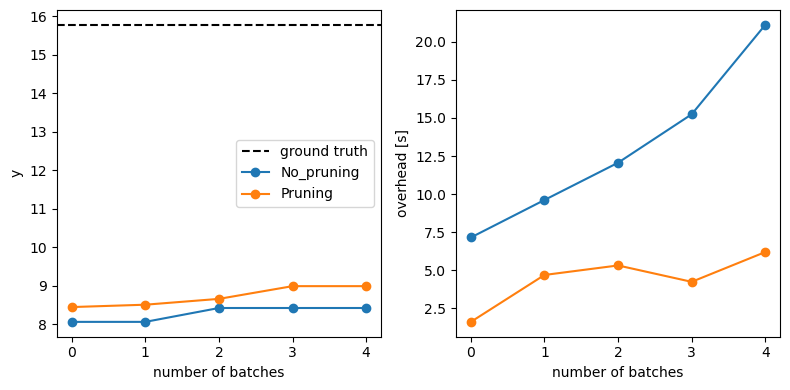

In [6]:
visualise_results(results_all, labels)

Pruning is generally performs better.<br>
Pruning is to squeeze the candidates for kernel recombination based on $\pi$.<br>
This is basically the same with $\pi$ shrinkage for normal types of variables we saw in Tutorial 02.<br>
Rather than passing all remaining data in the dataset to the quadrature solver, pruining limits the number of samples to pass based on $\pi$.

## 2. High-dim space is hard. Embedding mitigates a bit.
### See the difference in optimization in manifold or original space

We will use low rank PCA to embed the 2,048 binary features into 6 dim contiuous space

Visualise the 2-dimensional space just for getting intuitions

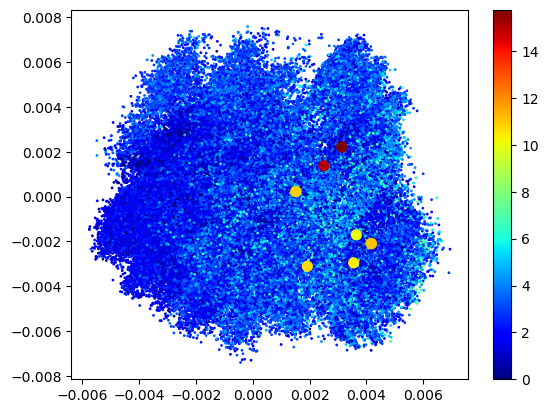

In [7]:
embedding, S, _ = torch.pca_lowrank(features, q=2)
plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    s=1,
    c=true_targets,
    vmax=true_targets.max(),
    vmin=true_targets.min(),
    cmap="jet",
)
plt.colorbar()

idx_largests = true_targets.argsort(descending=True)[:10]
plt.scatter(
    embedding[idx_largests, 0], 
    embedding[idx_largests, 1], 
    s=50,
    c=true_targets[idx_largests],
    vmax=true_targets.max(),
    vmin=true_targets.min(),
    cmap="jet",
)
plt.show()

The embedded space and properties are not correlated well.<br>
Still, optimization on 6 dimensional space is easier than 2,048 dim space.

In [8]:
embedding, S, _ = torch.pca_lowrank(features, q=6)

In [9]:
from SOBER._sober import Sober
from SOBER._gp import predict_mean

torch.manual_seed(seed)  # random seed

labels = ["No_embedding", "embedding"]
results_all = []
decay_all = []
for episode in labels:
    if episode == "No_embedding":
        prior = DatasetPrior(features, true_targets)
    elif episode == "embedding":
        prior = DatasetPrior(embedding, true_targets)
    # initialise
    
    Xall, Yall = prior.sample(n_init)  # Sampling not only features, but also true values.
    model = set_tanimoto_gp_model(Xall, Yall)
    sober = Sober(prior, model, dataset_pruning=pruning)

    results = []
    for n_iter in range(n_iterations):
        start = time.monotonic()
        model = set_rbf_model(Xall, Yall)
        model = optimise_model(model)
        sober.update_model(model)           # pass the updated model to sober
        idx_batch, X_batch = sober.next_batch(
            n_rec,
            n_nys,
            batch_size,
            calc_obj=obj,
            verbose=False,
        )
        end = time.monotonic()
        interval = end - start

        Y_batch = prior.query(idx_batch)      # query true values to the prior
        Xall = torch.cat((Xall, X_batch), dim=0)
        Yall = torch.cat((Yall, Y_batch), dim=0)

        print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
        print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
        results.append([interval, Yall.max().item()])

    results_all.append(results)

300) Best value: 7.58480e+00
Acquisition time [s]: 3.20609e+01, per sample [ms]: 1.60304e+02
500) Best value: 8.53510e+00
Acquisition time [s]: 3.65475e+00, per sample [ms]: 1.82738e+01
700) Best value: 8.53510e+00
Acquisition time [s]: 4.18727e+00, per sample [ms]: 2.09364e+01
900) Best value: 8.53510e+00
Acquisition time [s]: 5.88574e+00, per sample [ms]: 2.94287e+01
1100) Best value: 8.53510e+00
Acquisition time [s]: 8.23460e+00, per sample [ms]: 4.11730e+01
300) Best value: 8.89820e+00
Acquisition time [s]: 4.55209e+00, per sample [ms]: 2.27604e+01
500) Best value: 8.89820e+00
Acquisition time [s]: 5.33681e+00, per sample [ms]: 2.66840e+01
700) Best value: 8.89820e+00
Acquisition time [s]: 7.85954e-01, per sample [ms]: 3.92977e+00
900) Best value: 8.89820e+00
Acquisition time [s]: 8.83771e+00, per sample [ms]: 4.41885e+01
1100) Best value: 8.89820e+00
Acquisition time [s]: 1.19009e+01, per sample [ms]: 5.95044e+01


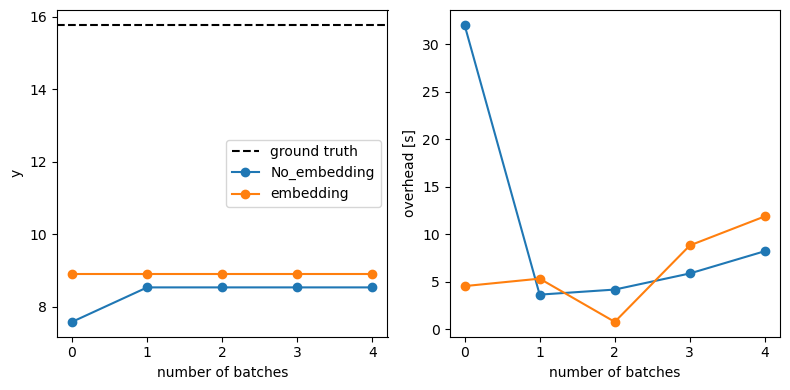

In [10]:
visualise_results(results_all, labels)

The embedding can accelerate the optimization.<br>
A better embedding, such as VAE or normalising flow, would result in better performance.

## 3. Effect of GP modelling.
We will see the effect of GP modelling.

We compare the modelling effect with different kernels:
1. Tanimoto kernel
2. Tanimoto kernel with mean weights
3. RBF kernel (6-dim PCA embedding)
4. RBF kernel with mean weights (6-dim PCA embedding)

The weighted kernels are the extension of the 

In [11]:
def decay_analysis(X, sober):
    weights = sober.pi(X)
    weights_decay = weights.sort(descending=True).values
    _, eigenvalue_decay, _ = torch.svd_lowrank(sober.kernel(X[:n_nys], X[:n_nys]), q=200)
    return (
        tm.numpy(weights_decay), 
        tm.numpy(eigenvalue_decay),
    )

def visualise_decays(ax, label, results):
    ax[0].plot(torch.arange(len(results[0]))+1, results[0], label=label)
    ax[0].legend()
    ax[0].set_xlabel("The best to least $\pi$")
    ax[0].set_ylabel("$\pi$")
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    
    ax[1].plot(torch.arange(len(results[1]))+1, results[1], label=label)
    ax[1].legend()
    ax[1].set_xlabel("The best to least Grammian elements")
    ax[1].set_ylabel("Eigenvalue")
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')

def visualise_decay_analysis(decay_all):
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
    for idx, decays in enumerate(decay_all):
        visualise_decays(ax, labels[idx], decays)
    plt.show()
    
def modelling(label, Xall, Yall):
    if label == "tanimoto":
        model = set_tanimoto_gp_model(Xall, Yall)
    elif label == "RBF":
        model = set_rbf_model(Xall, Yall)
    model = optimise_model(model)
    return model

In [12]:
from SOBER._sober import Sober
seed = 10                # random seed
torch.manual_seed(seed)  # random seed

results_all = []
decay_all = []
for pruning in [True, False]:
    for episode in [
        ("tanimoto","predictive_covariance"),
        ("tanimoto","weighted_predictive_covariance"),
        ("RBF", "predictive_covariance"),
        ("RBF","weighted_predictive_covariance"),
    ]:
        # initialise
        if episode[0] == "tanimoto":
            prior = DatasetPrior(features, true_targets)
        else:
            prior = DatasetPrior(embedding, true_targets)
        Xall, Yall = prior.sample(n_init)  # Sampling not only features, but also true values.

        model = modelling(episode[0], Xall, Yall)
        sober = Sober(
            prior, 
            model, 
            dataset_pruning=pruning,
            kernel_type=episode[1],
        )

        results = []
        for n_iter in range(n_iterations):
            start = time.monotonic()
            model = modelling(episode[0], Xall, Yall)
            sober.update_model(model)           # pass the updated model to sober
            idx_batch, X_batch = sober.next_batch(
                n_rec,
                n_nys,
                batch_size,
                calc_obj=obj,
                verbose=False,
            )
            end = time.monotonic()
            interval = end - start

            Y_batch = prior.query(idx_batch)      # query true values to the prior
            Xall = torch.cat((Xall, X_batch), dim=0)
            Yall = torch.cat((Yall, Y_batch), dim=0)

            print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
            print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
            results.append([interval, Yall.max().item()])

        results_all.append(results)
        if episode[0] == "tanimoto":
            results_decay = decay_analysis(features, sober)
        else:
            results_decay = decay_analysis(embedding, sober)
        decay_all.append(results_decay)

300) Best value: 7.79470e+00
Acquisition time [s]: 4.54478e+00, per sample [ms]: 2.27239e+01
500) Best value: 9.23740e+00
Acquisition time [s]: 4.19156e+00, per sample [ms]: 2.09578e+01
700) Best value: 9.23740e+00
Acquisition time [s]: 2.58319e+00, per sample [ms]: 1.29159e+01
900) Best value: 9.34060e+00
Acquisition time [s]: 3.72458e+00, per sample [ms]: 1.86229e+01
1100) Best value: 9.34060e+00
Acquisition time [s]: 3.80763e+01, per sample [ms]: 1.90381e+02
300) Best value: 8.19420e+00
Acquisition time [s]: 2.15973e+00, per sample [ms]: 1.07987e+01
500) Best value: 9.78740e+00
Acquisition time [s]: 4.17022e+00, per sample [ms]: 2.08511e+01
700) Best value: 1.50512e+01
Acquisition time [s]: 2.77813e+00, per sample [ms]: 1.38907e+01
703) Best value: 1.57709e+01
Acquisition time [s]: 4.25959e+00, per sample [ms]: 2.12979e+01
903) Best value: 1.57709e+01
Acquisition time [s]: 3.77097e+00, per sample [ms]: 1.88549e+01
300) Best value: 7.11810e+00
Acquisition time [s]: 3.45778e+00, per s

Visualise the results

Pruned results


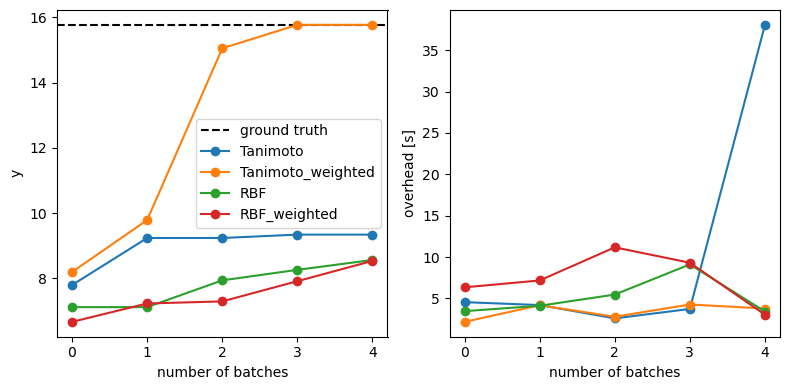

Non-pruned results


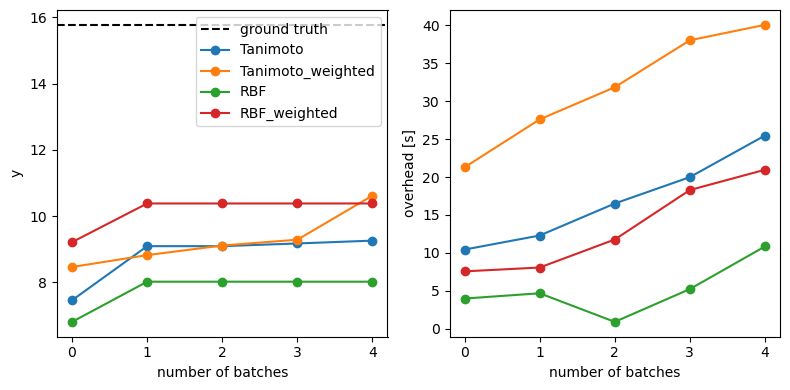

In [15]:
labels = ["Tanimoto","Tanimoto_weighted","RBF","RBF_weighted"]
print("Pruned results")
visualise_results(results_all[:4], labels)
print("Non-pruned results")
visualise_results(results_all[4:], labels)

Obviously, Tanimoto kernel and weighted kernels generally performs better. As weighted kernels are more exploitative than unweighted ones, it fits well to the largescale dataset that cannot explore all spaces. For pruing effect, this is impressively effective for weighted Tanimoto kernel, and others performs well in general.

### Spectral analysis on GP model
We will investigate in which aspect of GP modelling influenced on the optimisation convergence.<br>
We will lool at both $\pi$ and eigenvalue decay of the learnt GPs:

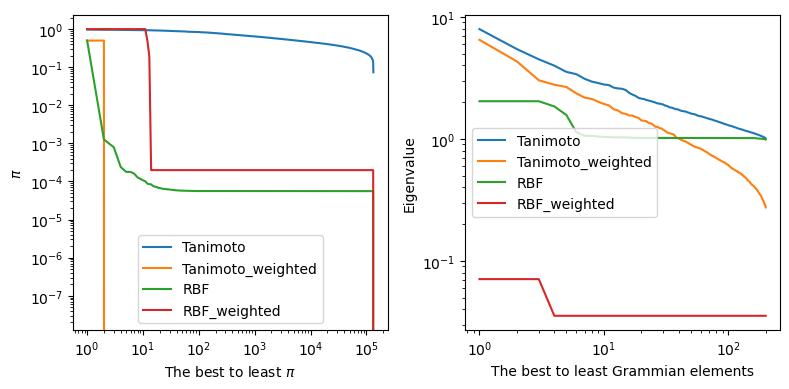

In [16]:
visualise_decay_analysis(decay_all[:4])

The left figure shows the decay on $\pi$. This explains the "shrinkage" of the probability distribution of global optimum location defined by $\pi$. On the other hand, the right figure shows the eigenvalue decay in the Grammian matrix. The eigenvalue decay corresponds to the relative performance of kernel quadrature. As kernel recombination aggressively utilise the eigenvalue decay information to select the quadrature points (batch querying), faster decay corresponds to the faster convergence in general.

In other words, $\pi$ decay corresponds to the "exploitation" ability, whereas the eigenvalue decay corresponds to the "exploration" ability. For $\pi$ decay, the weighted Tanimoto kernel decays significantly faster than others. On the other hand, the eigenvalues of the weighted RBF kernel decay faster than others. This explains the exploitation is more important for this dataset.